In [4]:
import os
import pandas as pd
import numpy as np
import utils
import optuna
from sklearn.model_selection import cross_val_score
import h2o
from h2o.automl import H2OAutoML


C:\Users\47901\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Data generation
Data has many columns with weather data, they are explained here: https://www.meteomatics.com/en/api/available-parameters/alphabetic-list



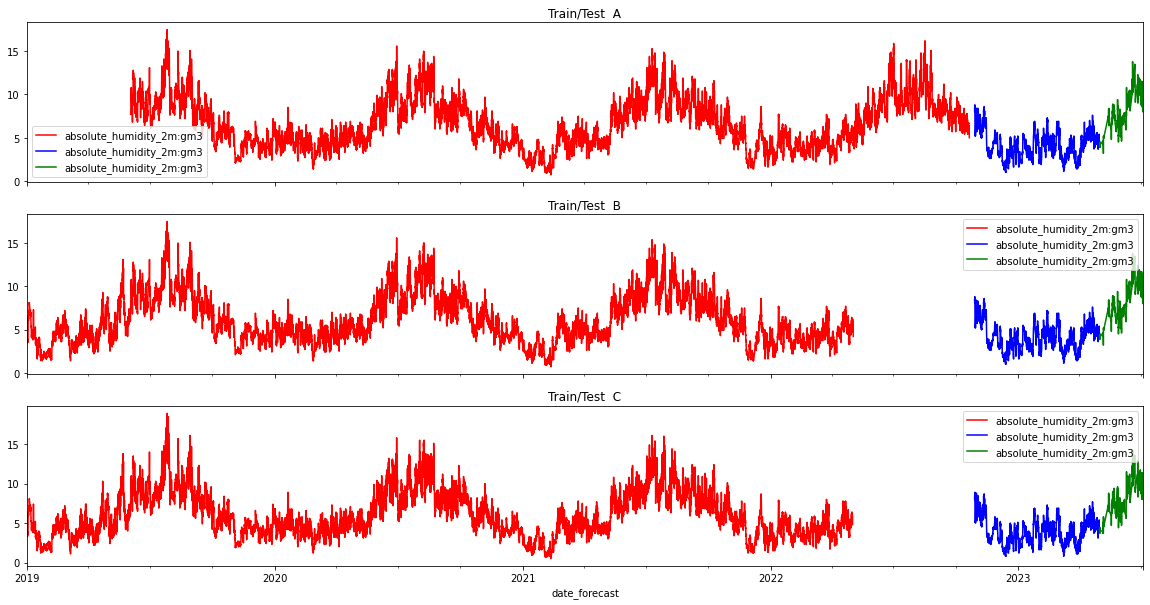

In [44]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

#%%

X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')


#%%

X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')


#%%

X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')


#%%

# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'absolute_humidity_2m:gm3'
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

In [27]:
# Explore location A
max_date = X_train_observed_a['date_forecast'].iloc[-1]
print(max_date)
train_a["time"] = pd.to_datetime(train_a['time'])
filtered_df_a = train_a[train_a['time'] <= max_date]

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)

hourly_X_train_obs_a = X_train_observed_a.resample('H').mean()
hourly_X_train_obs_a = hourly_X_train_obs_a.iloc[:-1]

2022-10-21 01:00:00


5733.42
date_forecast
2019-06-02 22:00:00    7.700
2019-06-02 23:00:00    7.700
2019-06-03 00:00:00    7.875
2019-06-03 01:00:00    8.425
2019-06-03 02:00:00    8.950
                       ...  
2022-10-20 20:00:00    5.800
2022-10-20 21:00:00    5.575
2022-10-20 22:00:00    5.350
2022-10-20 23:00:00    5.200
2022-10-21 00:00:00    5.000
Freq: H, Name: absolute_humidity_2m:gm3, Length: 29667, dtype: float32
Column Name :  absolute_humidity_2m:gm3


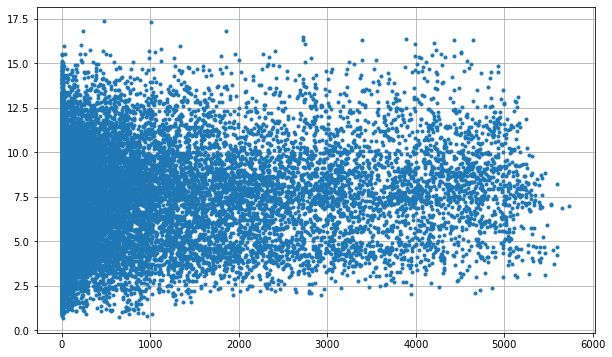

5733.42
date_forecast
2019-06-02 22:00:00    1.22825
2019-06-02 23:00:00    1.22350
2019-06-03 00:00:00    1.21975
2019-06-03 01:00:00    1.21800
2019-06-03 02:00:00    1.21800
                        ...   
2022-10-20 20:00:00    1.28050
2022-10-20 21:00:00    1.28400
2022-10-20 22:00:00    1.28700
2022-10-20 23:00:00    1.29050
2022-10-21 00:00:00    1.29200
Freq: H, Name: air_density_2m:kgm3, Length: 29667, dtype: float32
Column Name :  air_density_2m:kgm3


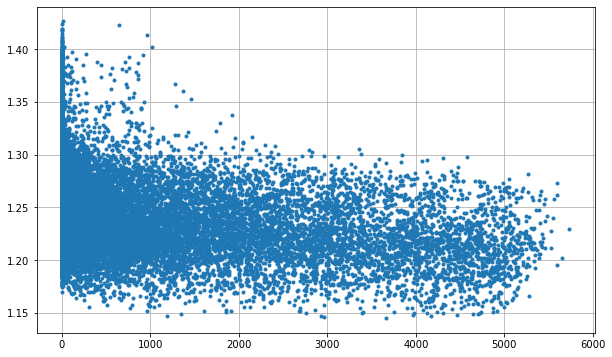

5733.42
date_forecast
2019-06-02 22:00:00    1728.949951
2019-06-02 23:00:00    1689.824951
2019-06-03 00:00:00    1563.224976
2019-06-03 01:00:00    1283.425049
2019-06-03 02:00:00    1003.500000
                          ...     
2022-10-20 20:00:00    1291.500000
2022-10-20 21:00:00            NaN
2022-10-20 22:00:00            NaN
2022-10-20 23:00:00            NaN
2022-10-21 00:00:00            NaN
Freq: H, Name: ceiling_height_agl:m, Length: 29667, dtype: float32
Column Name :  ceiling_height_agl:m


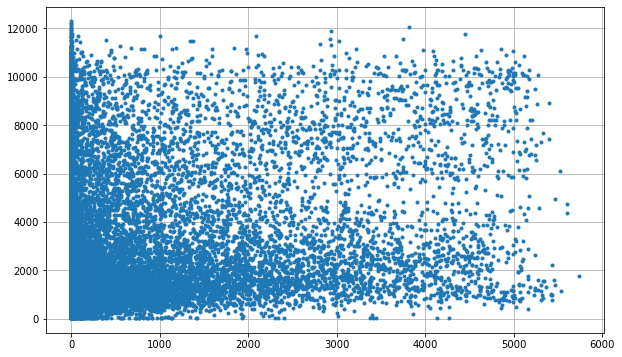

5733.42
date_forecast
2019-06-02 22:00:00        0.000000
2019-06-02 23:00:00        0.000000
2019-06-03 00:00:00        0.000000
2019-06-03 01:00:00      208.649994
2019-06-03 02:00:00    32468.150391
                           ...     
2022-10-20 20:00:00        0.000000
2022-10-20 21:00:00        0.000000
2022-10-20 22:00:00        0.000000
2022-10-20 23:00:00        0.000000
2022-10-21 00:00:00        0.000000
Freq: H, Name: clear_sky_energy_1h:J, Length: 29667, dtype: float32
Column Name :  clear_sky_energy_1h:J


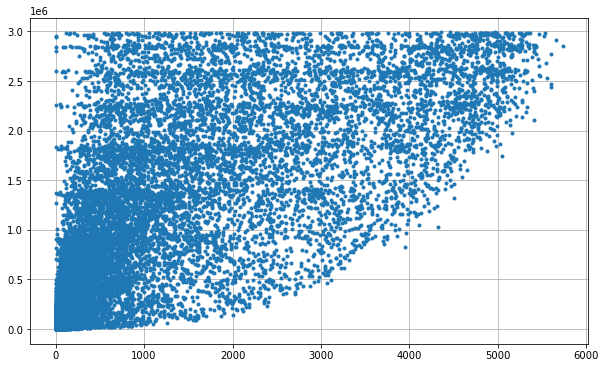

5733.42
date_forecast
2019-06-02 22:00:00     0.00
2019-06-02 23:00:00     0.00
2019-06-03 00:00:00     0.00
2019-06-03 01:00:00     0.75
2019-06-03 02:00:00    23.10
                       ...  
2022-10-20 20:00:00     0.00
2022-10-20 21:00:00     0.00
2022-10-20 22:00:00     0.00
2022-10-20 23:00:00     0.00
2022-10-21 00:00:00     0.00
Freq: H, Name: clear_sky_rad:W, Length: 29667, dtype: float32
Column Name :  clear_sky_rad:W


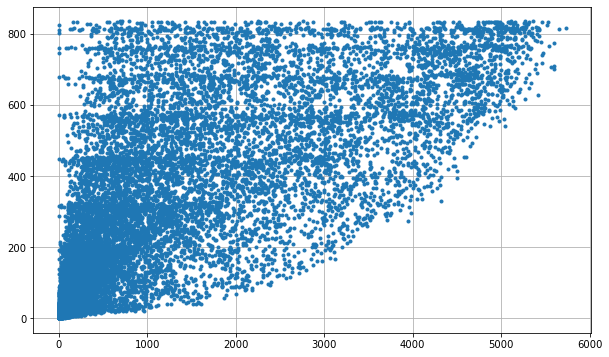

5733.42
date_forecast
2019-06-02 22:00:00    1728.949951
2019-06-02 23:00:00    1689.824951
2019-06-03 00:00:00    1563.224976
2019-06-03 01:00:00    1283.425049
2019-06-03 02:00:00    1003.500000
                          ...     
2022-10-20 20:00:00    1192.550049
2022-10-20 21:00:00     686.900024
2022-10-20 22:00:00     149.500000
2022-10-20 23:00:00            NaN
2022-10-21 00:00:00            NaN
Freq: H, Name: cloud_base_agl:m, Length: 29667, dtype: float32
Column Name :  cloud_base_agl:m


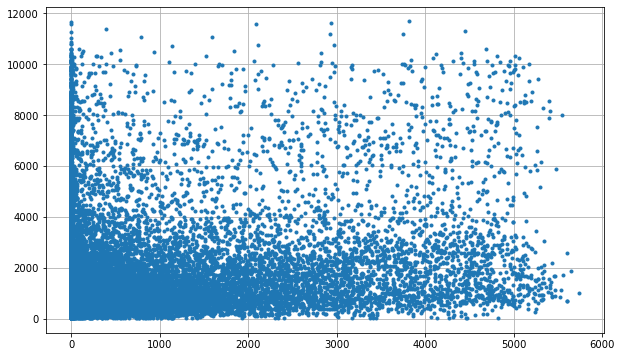

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: dew_or_rime:idx, Length: 29667, dtype: float32
Column Name :  dew_or_rime:idx


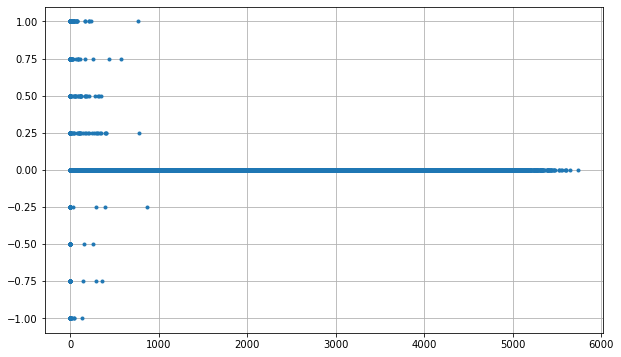

5733.42
date_forecast
2019-06-02 22:00:00    280.299988
2019-06-02 23:00:00    280.299988
2019-06-03 00:00:00    280.649994
2019-06-03 01:00:00    281.674988
2019-06-03 02:00:00    282.500000
                          ...    
2022-10-20 20:00:00    275.799988
2022-10-20 21:00:00    275.200012
2022-10-20 22:00:00    274.600006
2022-10-20 23:00:00    274.174988
2022-10-21 00:00:00    273.675018
Freq: H, Name: dew_point_2m:K, Length: 29667, dtype: float32
Column Name :  dew_point_2m:K


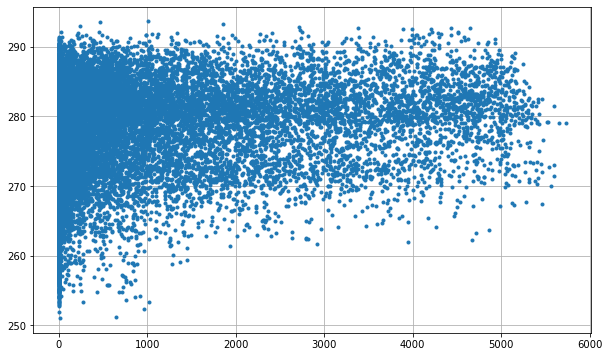

5733.42
date_forecast
2019-06-02 22:00:00     0.000
2019-06-02 23:00:00     0.000
2019-06-03 00:00:00     0.000
2019-06-03 01:00:00     0.300
2019-06-03 02:00:00    11.975
                        ...  
2022-10-20 20:00:00     0.000
2022-10-20 21:00:00     0.000
2022-10-20 22:00:00     0.000
2022-10-20 23:00:00     0.000
2022-10-21 00:00:00     0.000
Freq: H, Name: diffuse_rad:W, Length: 29667, dtype: float32
Column Name :  diffuse_rad:W


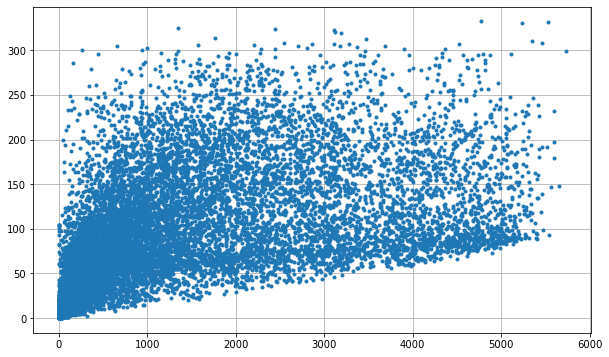

5733.42
date_forecast
2019-06-02 22:00:00        0.000000
2019-06-02 23:00:00        0.000000
2019-06-03 00:00:00        0.000000
2019-06-03 01:00:00      526.775024
2019-06-03 02:00:00    22068.949219
                           ...     
2022-10-20 20:00:00        0.000000
2022-10-20 21:00:00        0.000000
2022-10-20 22:00:00        0.000000
2022-10-20 23:00:00        0.000000
2022-10-21 00:00:00        0.000000
Freq: H, Name: diffuse_rad_1h:J, Length: 29667, dtype: float32
Column Name :  diffuse_rad_1h:J


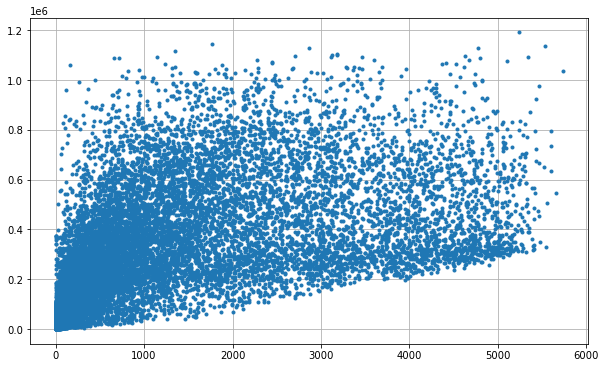

5733.42
date_forecast
2019-06-02 22:00:00    0.00
2019-06-02 23:00:00    0.00
2019-06-03 00:00:00    0.00
2019-06-03 01:00:00    0.00
2019-06-03 02:00:00    0.15
                       ... 
2022-10-20 20:00:00    0.00
2022-10-20 21:00:00    0.00
2022-10-20 22:00:00    0.00
2022-10-20 23:00:00    0.00
2022-10-21 00:00:00    0.00
Freq: H, Name: direct_rad:W, Length: 29667, dtype: float32
Column Name :  direct_rad:W


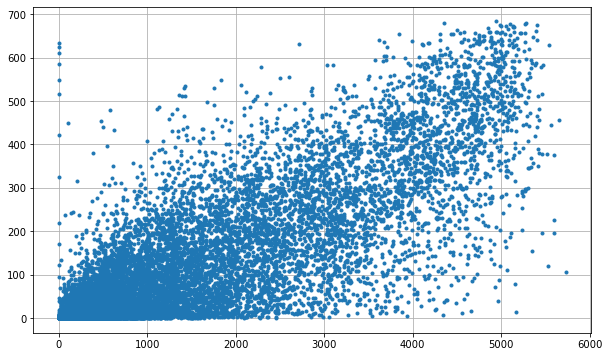

5733.42
date_forecast
2019-06-02 22:00:00      0.000000
2019-06-02 23:00:00      0.000000
2019-06-03 00:00:00      0.000000
2019-06-03 01:00:00      0.000000
2019-06-03 02:00:00    282.975006
                          ...    
2022-10-20 20:00:00      0.000000
2022-10-20 21:00:00      0.000000
2022-10-20 22:00:00      0.000000
2022-10-20 23:00:00      0.000000
2022-10-21 00:00:00      0.000000
Freq: H, Name: direct_rad_1h:J, Length: 29667, dtype: float32
Column Name :  direct_rad_1h:J


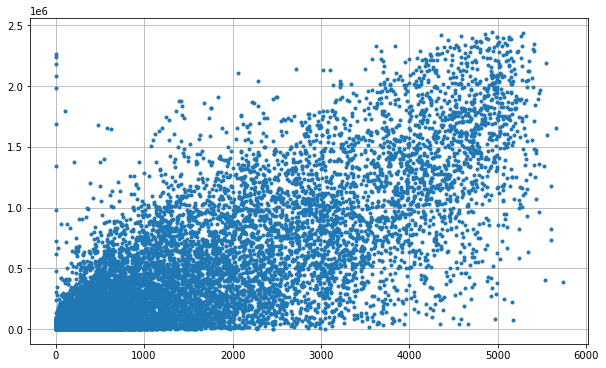

5733.42
date_forecast
2019-06-02 22:00:00     99.074997
2019-06-02 23:00:00     99.750000
2019-06-03 00:00:00    100.000000
2019-06-03 01:00:00    100.000000
2019-06-03 02:00:00     84.875000
                          ...    
2022-10-20 20:00:00     38.125000
2022-10-20 21:00:00     16.275000
2022-10-20 22:00:00      9.700000
2022-10-20 23:00:00      4.525000
2022-10-21 00:00:00      1.975000
Freq: H, Name: effective_cloud_cover:p, Length: 29667, dtype: float32
Column Name :  effective_cloud_cover:p


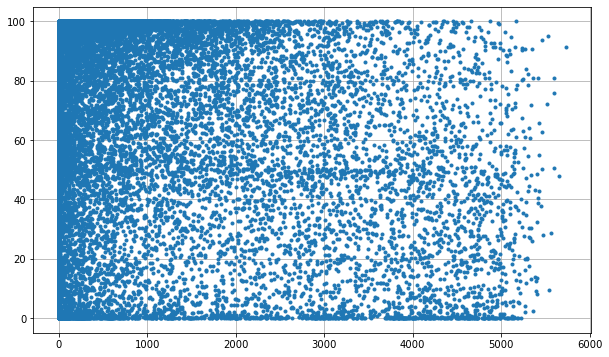

5733.42
date_forecast
2019-06-02 22:00:00    6.0
2019-06-02 23:00:00    6.0
2019-06-03 00:00:00    6.0
2019-06-03 01:00:00    6.0
2019-06-03 02:00:00    6.0
                      ... 
2022-10-20 20:00:00    6.0
2022-10-20 21:00:00    6.0
2022-10-20 22:00:00    6.0
2022-10-20 23:00:00    6.0
2022-10-21 00:00:00    6.0
Freq: H, Name: elevation:m, Length: 29667, dtype: float32
Column Name :  elevation:m


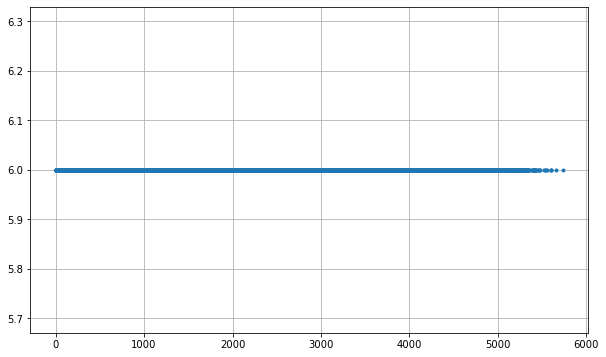

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: fresh_snow_12h:cm, Length: 29667, dtype: float32
Column Name :  fresh_snow_12h:cm


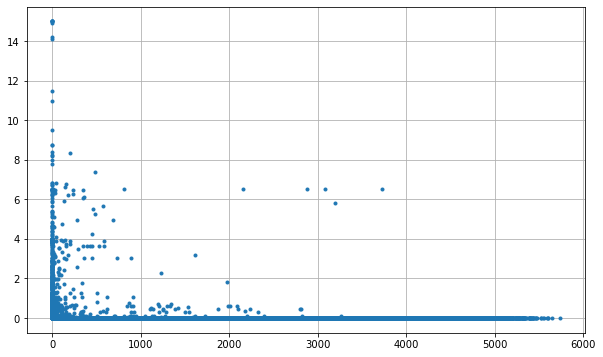

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: fresh_snow_1h:cm, Length: 29667, dtype: float32
Column Name :  fresh_snow_1h:cm


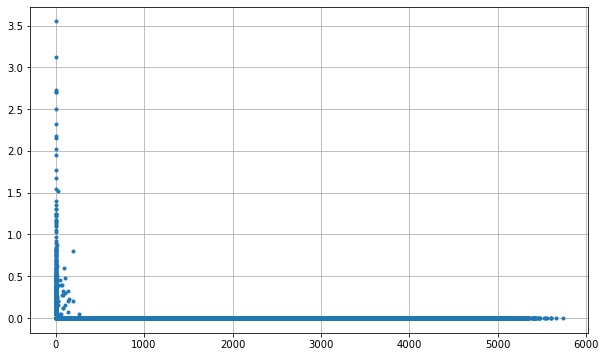

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: fresh_snow_24h:cm, Length: 29667, dtype: float32
Column Name :  fresh_snow_24h:cm


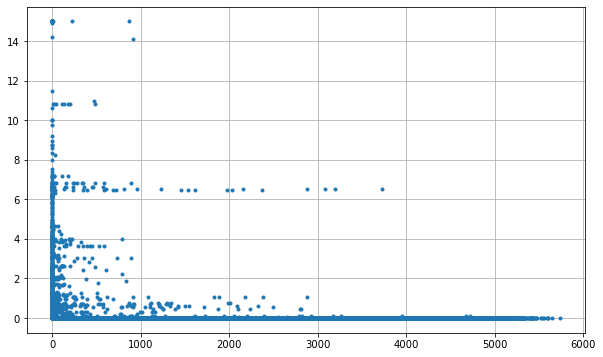

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: fresh_snow_3h:cm, Length: 29667, dtype: float32
Column Name :  fresh_snow_3h:cm


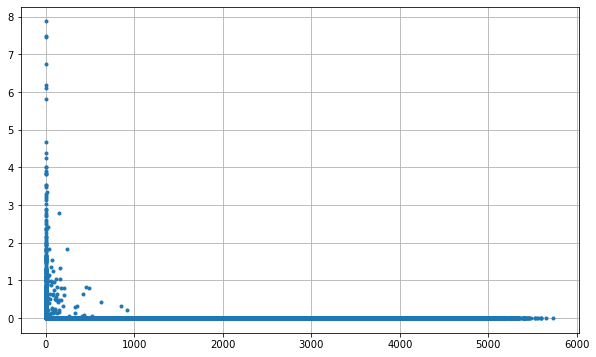

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: fresh_snow_6h:cm, Length: 29667, dtype: float32
Column Name :  fresh_snow_6h:cm


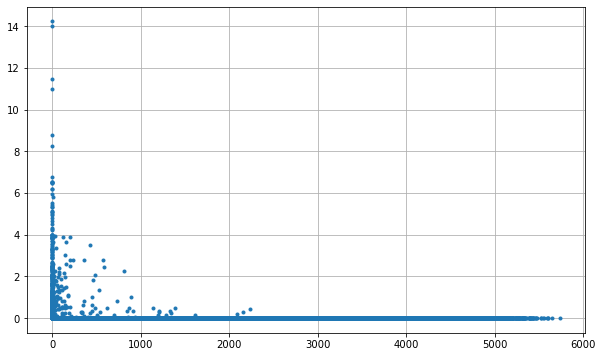

5733.42
date_forecast
2019-06-02 22:00:00    0.00
2019-06-02 23:00:00    0.00
2019-06-03 00:00:00    0.00
2019-06-03 01:00:00    0.25
2019-06-03 02:00:00    1.00
                       ... 
2022-10-20 20:00:00    0.00
2022-10-20 21:00:00    0.00
2022-10-20 22:00:00    0.00
2022-10-20 23:00:00    0.00
2022-10-21 00:00:00    0.00
Freq: H, Name: is_day:idx, Length: 29667, dtype: float32
Column Name :  is_day:idx


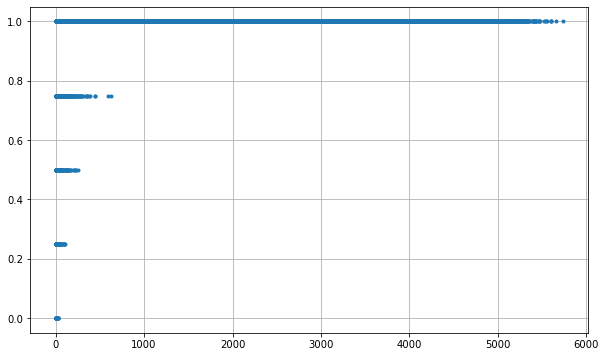

5733.42
date_forecast
2019-06-02 22:00:00    1.0
2019-06-02 23:00:00    1.0
2019-06-03 00:00:00    1.0
2019-06-03 01:00:00    1.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    1.0
2022-10-20 21:00:00    1.0
2022-10-20 22:00:00    1.0
2022-10-20 23:00:00    1.0
2022-10-21 00:00:00    1.0
Freq: H, Name: is_in_shadow:idx, Length: 29667, dtype: float32
Column Name :  is_in_shadow:idx


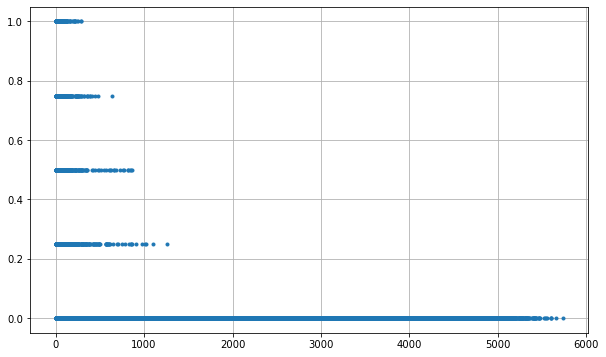

5733.42
date_forecast
2019-06-02 22:00:00    1006.299988
2019-06-02 23:00:00    1005.200012
2019-06-03 00:00:00    1004.525024
2019-06-03 01:00:00    1004.025024
2019-06-03 02:00:00    1003.099976
                          ...     
2022-10-20 20:00:00    1019.500000
2022-10-20 21:00:00    1019.250000
2022-10-20 22:00:00    1018.974976
2022-10-20 23:00:00    1018.650024
2022-10-21 00:00:00    1018.224976
Freq: H, Name: msl_pressure:hPa, Length: 29667, dtype: float32
Column Name :  msl_pressure:hPa


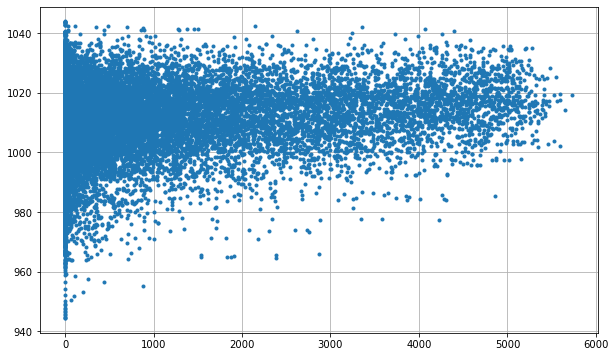

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: precip_5min:mm, Length: 29667, dtype: float32
Column Name :  precip_5min:mm


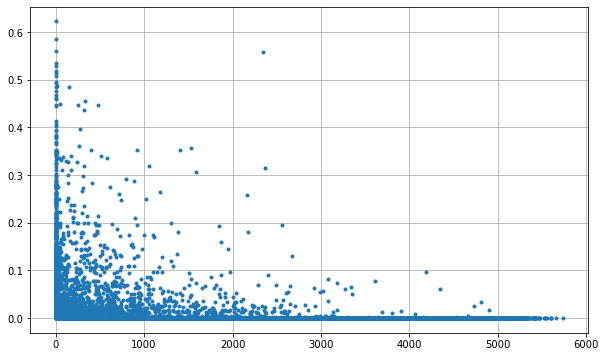

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: precip_type_5min:idx, Length: 29667, dtype: float32
Column Name :  precip_type_5min:idx


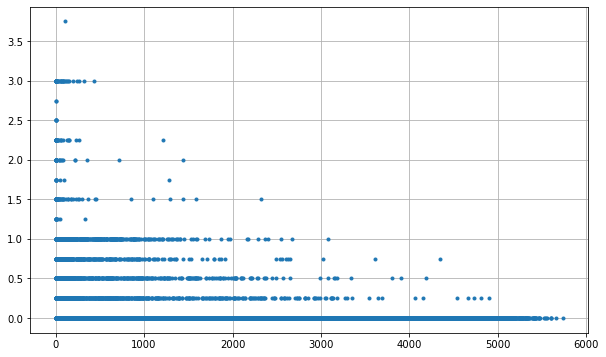

5733.42
date_forecast
2019-06-02 22:00:00     993.750000
2019-06-02 23:00:00     992.674988
2019-06-03 00:00:00     992.000000
2019-06-03 01:00:00     991.500000
2019-06-03 02:00:00     990.550049
                          ...     
2022-10-20 20:00:00    1006.599976
2022-10-20 21:00:00    1006.375000
2022-10-20 22:00:00    1006.099976
2022-10-20 23:00:00    1005.775024
2022-10-21 00:00:00    1005.325012
Freq: H, Name: pressure_100m:hPa, Length: 29667, dtype: float32
Column Name :  pressure_100m:hPa


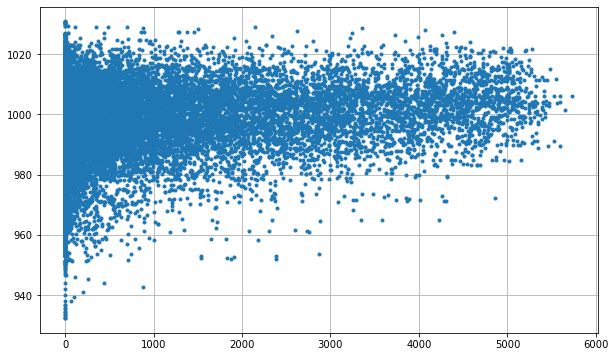

5733.42
date_forecast
2019-06-02 22:00:00     999.775024
2019-06-02 23:00:00     998.650024
2019-06-03 00:00:00     997.974976
2019-06-03 01:00:00     997.449951
2019-06-03 02:00:00     996.500000
                          ...     
2022-10-20 20:00:00    1012.849976
2022-10-20 21:00:00    1012.625000
2022-10-20 22:00:00    1012.349976
2022-10-20 23:00:00    1012.049988
2022-10-21 00:00:00    1011.625000
Freq: H, Name: pressure_50m:hPa, Length: 29667, dtype: float32
Column Name :  pressure_50m:hPa


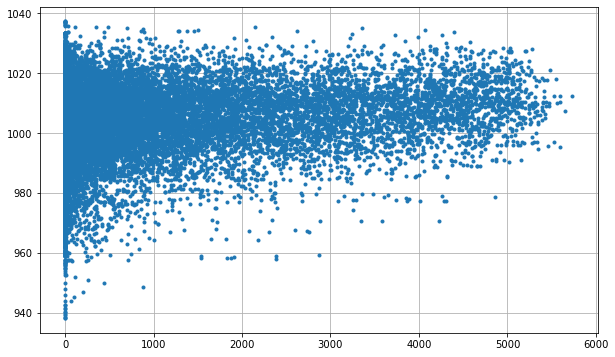

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: prob_rime:p, Length: 29667, dtype: float32
Column Name :  prob_rime:p


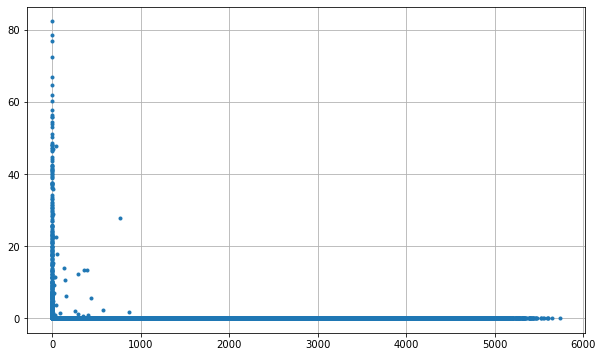

5733.42
date_forecast
2019-06-02 22:00:00    0.000
2019-06-02 23:00:00    0.025
2019-06-03 00:00:00    0.100
2019-06-03 01:00:00    0.125
2019-06-03 02:00:00    0.100
                       ...  
2022-10-20 20:00:00    0.000
2022-10-20 21:00:00    0.000
2022-10-20 22:00:00    0.000
2022-10-20 23:00:00    0.000
2022-10-21 00:00:00    0.000
Freq: H, Name: rain_water:kgm2, Length: 29667, dtype: float32
Column Name :  rain_water:kgm2


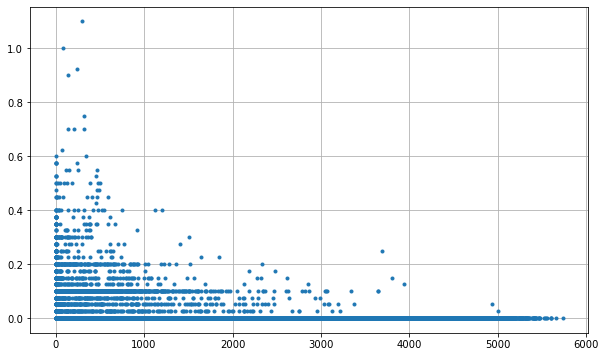

5733.42
date_forecast
2019-06-02 22:00:00    71.674995
2019-06-02 23:00:00    68.000000
2019-06-03 00:00:00    67.949997
2019-06-03 01:00:00    73.875000
2019-06-03 02:00:00    79.925003
                         ...    
2022-10-20 20:00:00    78.649994
2022-10-20 21:00:00    79.125000
2022-10-20 22:00:00    79.974998
2022-10-20 23:00:00    81.199997
2022-10-21 00:00:00    83.250000
Freq: H, Name: relative_humidity_1000hPa:p, Length: 29667, dtype: float32
Column Name :  relative_humidity_1000hPa:p


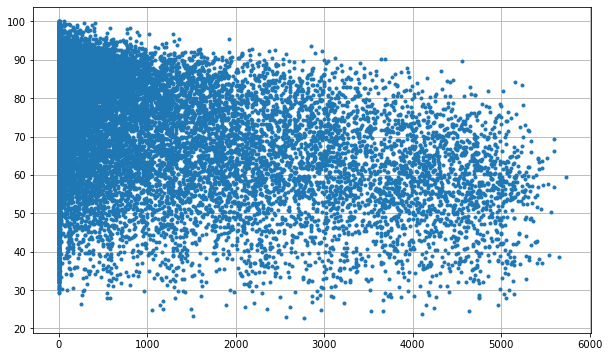

5733.42
date_forecast
2019-06-02 22:00:00    1005.799988
2019-06-02 23:00:00    1004.650024
2019-06-03 00:00:00    1003.950012
2019-06-03 01:00:00    1003.449951
2019-06-03 02:00:00    1002.500000
                          ...     
2022-10-20 20:00:00    1019.125000
2022-10-20 21:00:00    1018.900024
2022-10-20 22:00:00    1018.650024
2022-10-20 23:00:00    1018.349976
2022-10-21 00:00:00    1017.924988
Freq: H, Name: sfc_pressure:hPa, Length: 29667, dtype: float32
Column Name :  sfc_pressure:hPa


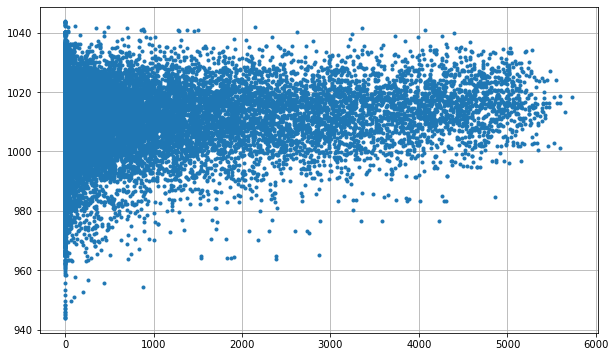

5733.42
date_forecast
2019-06-02 22:00:00   NaN
2019-06-02 23:00:00   NaN
2019-06-03 00:00:00   NaN
2019-06-03 01:00:00   NaN
2019-06-03 02:00:00   NaN
                       ..
2022-10-20 20:00:00   NaN
2022-10-20 21:00:00   NaN
2022-10-20 22:00:00   NaN
2022-10-20 23:00:00   NaN
2022-10-21 00:00:00   NaN
Freq: H, Name: snow_density:kgm3, Length: 29667, dtype: float32
Column Name :  snow_density:kgm3


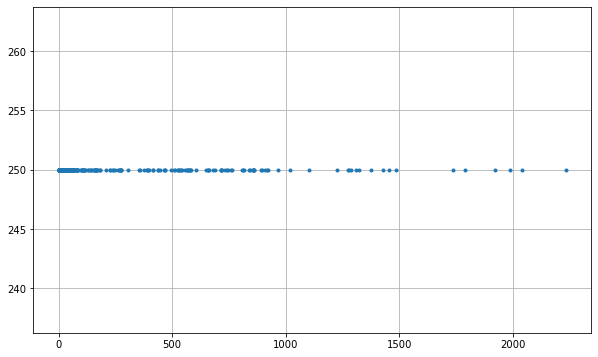

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: snow_depth:cm, Length: 29667, dtype: float32
Column Name :  snow_depth:cm


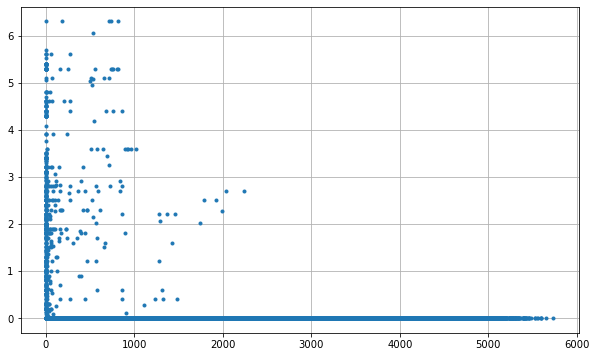

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: snow_drift:idx, Length: 29667, dtype: float32
Column Name :  snow_drift:idx


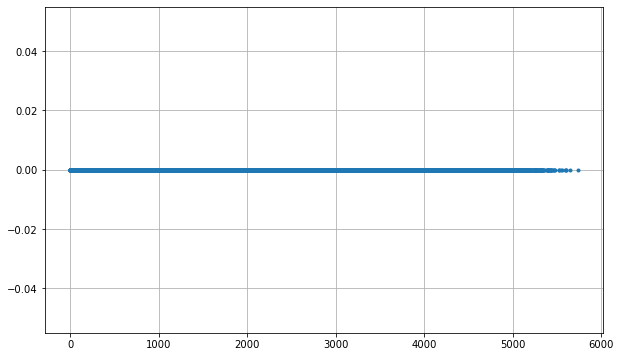

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: snow_melt_10min:mm, Length: 29667, dtype: float32
Column Name :  snow_melt_10min:mm


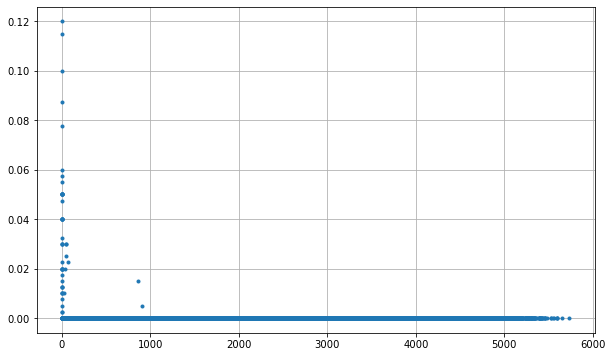

5733.42
date_forecast
2019-06-02 22:00:00    0.175
2019-06-02 23:00:00    0.200
2019-06-03 00:00:00    0.400
2019-06-03 01:00:00    0.550
2019-06-03 02:00:00    0.250
                       ...  
2022-10-20 20:00:00    0.000
2022-10-20 21:00:00    0.000
2022-10-20 22:00:00    0.000
2022-10-20 23:00:00    0.000
2022-10-21 00:00:00    0.000
Freq: H, Name: snow_water:kgm2, Length: 29667, dtype: float32
Column Name :  snow_water:kgm2


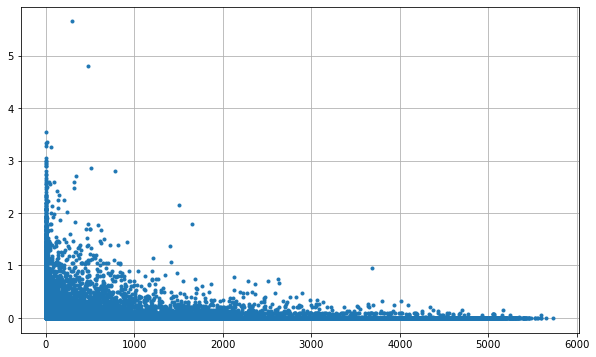

5733.42
date_forecast
2019-06-02 22:00:00    348.036743
2019-06-02 23:00:00     91.980751
2019-06-03 00:00:00     14.934750
2019-06-03 01:00:00     28.630251
2019-06-03 02:00:00     41.997501
                          ...    
2022-10-20 20:00:00    313.254761
2022-10-20 21:00:00    329.987762
2022-10-20 22:00:00    347.845490
2022-10-20 23:00:00     96.250496
2022-10-21 00:00:00     23.331749
Freq: H, Name: sun_azimuth:d, Length: 29667, dtype: float32
Column Name :  sun_azimuth:d


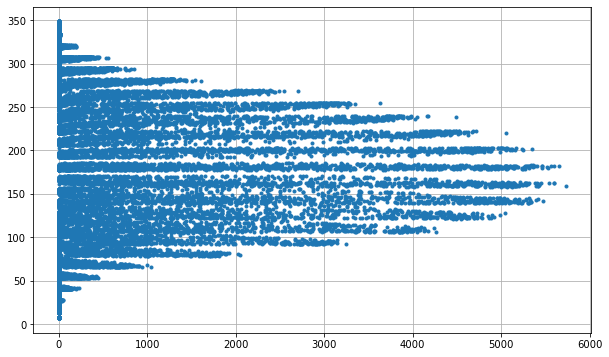

5733.42
date_forecast
2019-06-02 22:00:00    -3.774250
2019-06-02 23:00:00    -4.357250
2019-06-03 00:00:00    -3.309500
2019-06-03 01:00:00    -0.822500
2019-06-03 02:00:00     3.051250
                         ...    
2022-10-20 20:00:00   -29.704250
2022-10-20 21:00:00   -33.860748
2022-10-20 22:00:00   -36.270000
2022-10-20 23:00:00   -36.614998
2022-10-21 00:00:00   -35.368500
Freq: H, Name: sun_elevation:d, Length: 29667, dtype: float32
Column Name :  sun_elevation:d


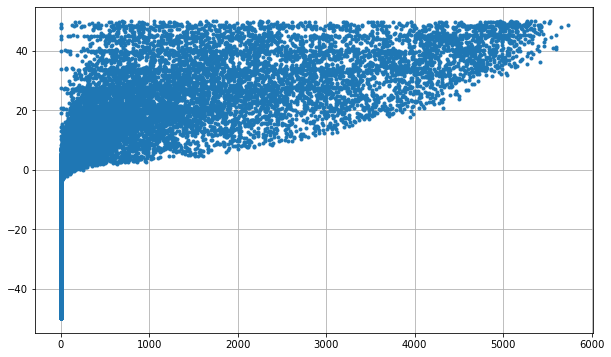

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: super_cooled_liquid_water:kgm2, Length: 29667, dtype: float32
Column Name :  super_cooled_liquid_water:kgm2


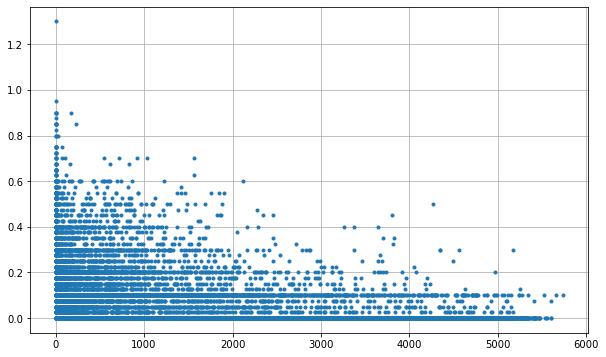

5733.42
date_forecast
2019-06-02 22:00:00    286.225006
2019-06-02 23:00:00    286.899994
2019-06-03 00:00:00    286.950012
2019-06-03 01:00:00    286.750000
2019-06-03 02:00:00    286.450012
                          ...    
2022-10-20 20:00:00    278.250000
2022-10-20 21:00:00    277.850006
2022-10-20 22:00:00    277.475006
2022-10-20 23:00:00    277.149994
2022-10-21 00:00:00    276.700012
Freq: H, Name: t_1000hPa:K, Length: 29667, dtype: float32
Column Name :  t_1000hPa:K


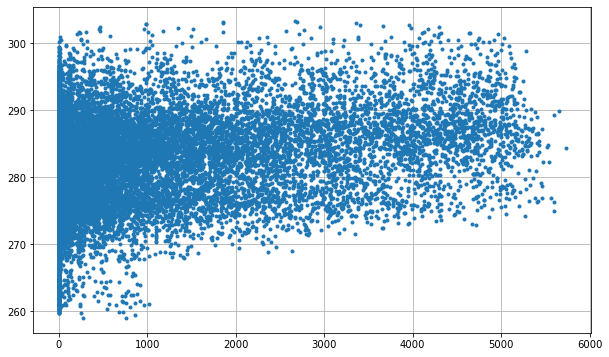

5733.42
date_forecast
2019-06-02 22:00:00    100.000000
2019-06-02 23:00:00    100.000000
2019-06-03 00:00:00    100.000000
2019-06-03 01:00:00    100.000000
2019-06-03 02:00:00     99.224998
                          ...    
2022-10-20 20:00:00     47.050003
2022-10-20 21:00:00     19.500000
2022-10-20 22:00:00      9.700000
2022-10-20 23:00:00      4.525000
2022-10-21 00:00:00      1.975000
Freq: H, Name: total_cloud_cover:p, Length: 29667, dtype: float32
Column Name :  total_cloud_cover:p


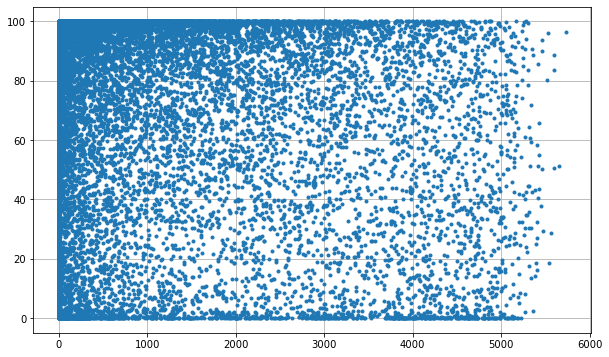

5733.42
date_forecast
2019-06-02 22:00:00    40386.476562
2019-06-02 23:00:00    33770.648438
2019-06-03 00:00:00    13595.500000
2019-06-03 01:00:00     2321.850098
2019-06-03 02:00:00    11634.799805
                           ...     
2022-10-20 20:00:00    40105.472656
2022-10-20 21:00:00    39001.398438
2022-10-20 22:00:00    35336.726562
2022-10-20 23:00:00    27164.625000
2022-10-21 00:00:00    29933.000000
Freq: H, Name: visibility:m, Length: 29667, dtype: float32
Column Name :  visibility:m


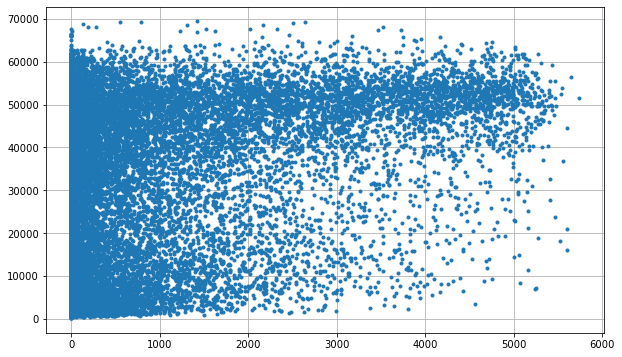

5733.42
date_forecast
2019-06-02 22:00:00    3.600
2019-06-02 23:00:00    3.350
2019-06-03 00:00:00    3.050
2019-06-03 01:00:00    2.725
2019-06-03 02:00:00    2.550
                       ...  
2022-10-20 20:00:00    1.925
2022-10-20 21:00:00    1.675
2022-10-20 22:00:00    1.400
2022-10-20 23:00:00    1.300
2022-10-21 00:00:00    1.400
Freq: H, Name: wind_speed_10m:ms, Length: 29667, dtype: float32
Column Name :  wind_speed_10m:ms


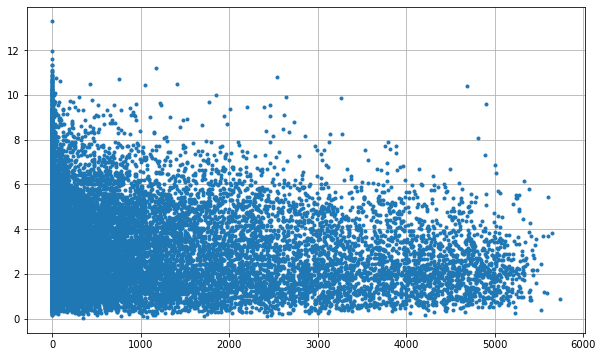

5733.42
date_forecast
2019-06-02 22:00:00   -3.575
2019-06-02 23:00:00   -3.350
2019-06-03 00:00:00   -2.950
2019-06-03 01:00:00   -2.600
2019-06-03 02:00:00   -2.350
                       ...  
2022-10-20 20:00:00    0.475
2022-10-20 21:00:00    0.250
2022-10-20 22:00:00    0.050
2022-10-20 23:00:00   -0.175
2022-10-21 00:00:00   -0.700
Freq: H, Name: wind_speed_u_10m:ms, Length: 29667, dtype: float32
Column Name :  wind_speed_u_10m:ms


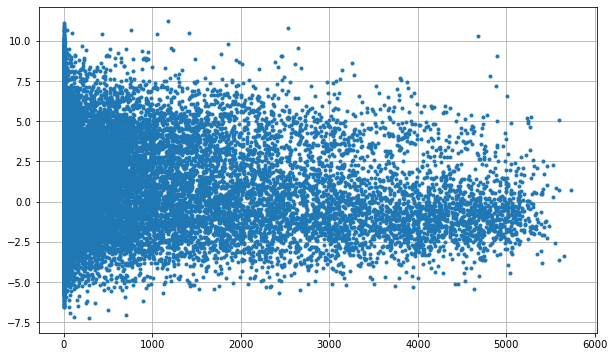

5733.42
date_forecast
2019-06-02 22:00:00   -0.500
2019-06-02 23:00:00    0.275
2019-06-03 00:00:00    0.750
2019-06-03 01:00:00    0.875
2019-06-03 02:00:00    0.925
                       ...  
2022-10-20 20:00:00    1.850
2022-10-20 21:00:00    1.675
2022-10-20 22:00:00    1.400
2022-10-20 23:00:00    1.300
2022-10-21 00:00:00    1.175
Freq: H, Name: wind_speed_v_10m:ms, Length: 29667, dtype: float32
Column Name :  wind_speed_v_10m:ms


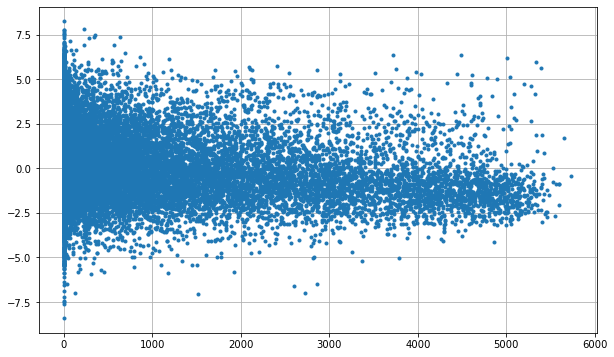

5733.42
date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2022-10-20 20:00:00    0.0
2022-10-20 21:00:00    0.0
2022-10-20 22:00:00    0.0
2022-10-20 23:00:00    0.0
2022-10-21 00:00:00    0.0
Freq: H, Name: wind_speed_w_1000hPa:ms, Length: 29667, dtype: float32
Column Name :  wind_speed_w_1000hPa:ms


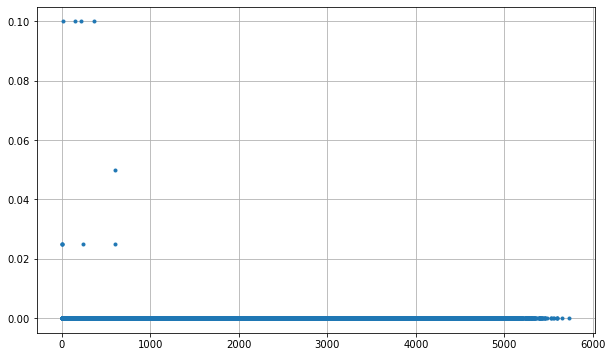

In [32]:
for column in hourly_X_train_obs_a.columns:
    power = filtered_df_a["pv_measurement"]
    power = power.values.flatten()
    print(power.max())
    print(hourly_X_train_obs_a[column])
    print('Column Name : ', column)
    plt.figure(figsize=(10, 6))
    plt.plot(power, hourly_X_train_obs_a[column].to_numpy(), marker='.', linestyle='')
    plt.grid(True)
    plt.show()

In [45]:
max_date = X_train_observed_b['date_forecast'].iloc[-1]
print(max_date)
train_b['time'] = pd.to_datetime(train_b['time'])
filtered_df_b = train_b[train_b['time'] <= max_date]
print(filtered_df_b['time'].iloc[-1])
X_train_observed_b['date_forecast_dt'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast_dt', inplace=True)

hourly_X_train_obs_b = X_train_observed_b.resample('H').mean()
hourly_X_train_obs_b = hourly_X_train_obs_b.iloc[:-10]

2022-05-03 00:00:00
2022-05-02 23:00:00


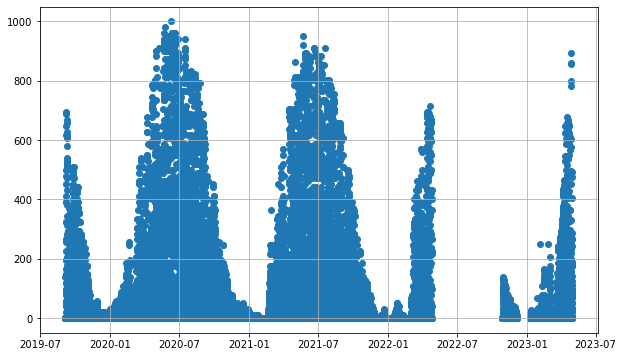

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(train_c['time'], train_c['pv_measurement'])
plt.grid(True)
plt.show()

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

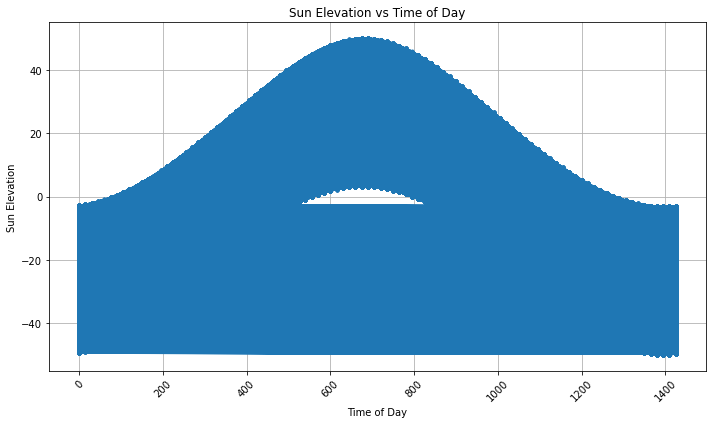

In [47]:
print(X_train_observed_b.columns)
X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])

# Extract time of day
X_train_observed_b['time_of_day'] = X_train_observed_b['date_forecast'].dt.time
X_train_observed_b['minutes_since_midnight'] = X_train_observed_b['time_of_day'].apply(lambda x: x.hour * 60 + x.minute)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train_observed_b['minutes_since_midnight'].to_numpy(), X_train_observed_b['sun_elevation:d'].to_numpy(), marker='.')
plt.xlabel('Time of Day')
plt.ylabel('Sun Elevation')
plt.title('Sun Elevation vs Time of Day')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
df, tuning_data, x_test = utils.preprocess_category_estimated_observed('A')
#df = pd.read_csv('raw_predictions/ABC_A.csv')
df['date_forecast'] = pd.to_datetime(df['date_forecast'])
mask = (df['date_forecast'].dt.month >= 5) & (df['date_forecast'].dt.month <= 7) & (df['date_forecast'].dt.day >= 1) & ((df['date_forecast'].dt.month != 7) | (df['date_forecast'].dt.day <= 3))
filtered_df = df.loc[mask]

# Group by year and calculate the average of 'pv_measurement'
average_pv_measurement = filtered_df.groupby(filtered_df['date_forecast'].dt.year)['pv_measurement'].mean()


Total data points: 34085
Data points to be removed: 0


In [27]:
print(average_pv_measurement)

date_forecast
2019     947.444745
2020    1343.293789
2021    1436.071198
2022    1205.563620
Name: pv_measurement, dtype: float64


In [49]:
# Util functions

def onehot_months(df):
    new_df = df.copy()
    new_df['month'] = df['date_forecast'].dt.month
    # Perform one-hot encoding
    new_df = pd.get_dummies(new_df, columns=['month', ])
    for i in range(12):
        if not f'month_{i + 1}' in new_df:
            new_df[f'month_{i + 1}'] = False

    return new_df


def onehot_hours(df):
    new_df = df.copy()
    new_df['hour'] = df['date_forecast'].dt.hour
    # Perform one-hot encoding
    new_df = pd.get_dummies(new_df, columns=['hour', ])

    return new_df


def concat_observed_estimated(obs_df, est_df):
    new_df = pd.concat([obs_df, est_df], ignore_index=True)
    return new_df


def merge_train_target(train_df, target_df):
    merged_df = target_df.merge(train_df, left_on='time', right_on='date_forecast')
    return merged_df


def clean_target_data(target_df, zero_threshold=150, constant_value_threshold=1):
    # This method removes any sets in the data where there are 150 or more consecutive identical values
    target_df = target_df.copy()

    target_df = target_df.dropna(subset=['pv_measurement'])

    zero_sequences = (target_df['pv_measurement'] == 0).astype(int).groupby(
        target_df['pv_measurement'].ne(0).cumsum()).cumsum()
    
    constant_sequences = (target_df['pv_measurement'].eq(target_df['pv_measurement'].shift()) & (
            target_df['pv_measurement'] != 0)).astype(int).groupby(
        target_df['pv_measurement'].ne(target_df['pv_measurement'].shift()).cumsum()).cumsum()

    remove_zeros = zero_sequences > zero_threshold
    remove_constants = constant_sequences > constant_value_threshold

    to_remove = remove_zeros | remove_constants

    total_data_points = len(target_df)
    removed_data_points = to_remove.sum()

    print(f"Total data points: {total_data_points}")
    print(f"Data points to be removed: {removed_data_points}")

    cleaned_target = target_df[~to_remove].reset_index(drop=True)

    return cleaned_target


def preprocess_category_estimated_observed(category: str):
    category = category.upper()

    target_df = pd.read_parquet(f'data/{category}/train_targets.parquet')
    estimated_df = pd.read_parquet(f'data/{category}/X_train_estimated.parquet')
    observed_df = pd.read_parquet(f'data/{category}/X_train_observed.parquet')
    test_df = pd.read_parquet(f'data/{category}/X_test_estimated.parquet')

    cleaned_target = clean_target_data(target_df=target_df)

    # Observed
    observed_df['date_forecast'] = pd.to_datetime(observed_df['date_forecast'])
    observed_df.set_index('date_forecast', inplace=True)
    observed_df = observed_df.resample('H').mean()
    observed_df = observed_df.reset_index()

    observed_df = onehot_hours(observed_df)
    observed_df = onehot_months(observed_df)

    # Estimated
    estimated_df['date_forecast'] = pd.to_datetime(estimated_df['date_forecast'])
    estimated_df.set_index('date_forecast', inplace=True)
    estimated_df = estimated_df.resample('H').mean()
    estimated_df = estimated_df.reset_index()

    estimated_df = onehot_hours(estimated_df)
    estimated_df = onehot_months(estimated_df)

    # Test
    test_df['date_forecast'] = pd.to_datetime(test_df['date_forecast'])
    test_df.set_index('date_forecast', inplace=True)
    test_df = test_df.resample('H').mean()
    preprocessed_test = test_df.reset_index()

    preprocessed_test = onehot_hours(preprocessed_test)
    preprocessed_test = onehot_months(preprocessed_test)

    observed_target = merge_train_target(observed_df, cleaned_target)
    observed_target.fillna(0, inplace=True)

    estimated_target = merge_train_target(estimated_df, cleaned_target)
    estimated_target.fillna(0, inplace=True)

    return observed_target.reindex(sorted(observed_target.columns), axis=1), \
           estimated_target.reindex(sorted(estimated_target.columns), axis=1), \
           preprocessed_test.reindex(sorted(preprocessed_test.columns), axis=1)


def preprocess_category(category: str):
    category = category.upper()

    target_df = pd.read_parquet(f'data/{category}/train_targets.parquet')
    estimated_df = pd.read_parquet(f'data/{category}/X_train_estimated.parquet')
    observed_df = pd.read_parquet(f'data/{category}/X_train_observed.parquet')
    test_df = pd.read_parquet(f'data/{category}/X_test_estimated.parquet')

    cleaned_target = clean_target_data(target_df=target_df)

    preprocessed_df = concat_observed_estimated(observed_df, estimated_df)

    preprocessed_df['date_forecast'] = pd.to_datetime(preprocessed_df['date_forecast'])
    preprocessed_df.set_index('date_forecast', inplace=True)
    preprocessed_df = preprocessed_df.resample('H').mean()
    preprocessed_df = preprocessed_df.reset_index()

    # One-hot encode both hours of the day and months
    preprocessed_df = onehot_hours(preprocessed_df)
    preprocessed_df = onehot_months(preprocessed_df)

    # Test
    test_df['date_forecast'] = pd.to_datetime(test_df['date_forecast'])
    test_df.set_index('date_forecast', inplace=True)
    test_df = test_df.resample('H').mean()
    preprocessed_test = test_df.reset_index()

    preprocessed_test = onehot_hours(preprocessed_test)
    preprocessed_test = onehot_months(preprocessed_test)

    preprocessed_df = merge_train_target(preprocessed_df, cleaned_target)
    preprocessed_df.fillna(0, inplace=True)

    return preprocessed_df.reindex(sorted(preprocessed_df.columns), axis=1), preprocessed_test.reindex(
        sorted(preprocessed_test.columns), axis=1)


In [57]:
def run_h2o(location):
    x_train, x_test = preprocess_category(location)
    x_train.drop(["time", "date_calc", "snow_density:kgm3"], axis=1, inplace=True)
    x_test.drop(["date_calc", "snow_density:kgm3"], axis=1, inplace=True)
    x_train['date_forecast'] = (pd.to_datetime(x_train['date_forecast'], format='%Y') - pd.to_datetime('2000', format='%Y')).dt.total_seconds()
    x_test['date_forecast_dt'] = x_test['date_forecast']
    x_test['date_forecast'] = (pd.to_datetime(x_test['date_forecast'], format='%Y') - pd.to_datetime('2000', format='%Y')).dt.total_seconds()

    h2o.init()

    aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=10)
    aml.train(x=list(x_train.drop('pv_measurement', axis=1).columns), y='pv_measurement', training_frame=h2o.H2OFrame(x_train))

    print('Leader:-----------------------------------------------------------   ')
    print(aml.leader)

    preds = aml.predict(h2o.H2OFrame(x_test))
    print(preds)
    y_pred = h2o.as_list(preds)

    preds = pd.DataFrame()
    preds['date_forecast'] = x_test['date_forecast_dt']
    preds['predicted'] = np.asarray(y_pred)
    preds.to_csv('h2o_normalized_with_OneHot' + location + '.csv', index=False)


##run_h2o('A')
#run_h2o('B')
#run_h2o('C')


In [11]:
def average_two_csv(filename1, filename2):
    file1 = pd.read_csv(filename1)
    file2 = pd.read_csv(filename2)

    merged_df = file1.merge(file2, on='id', suffixes=('_df1', '_df2'))

    # Compute the average of the 'prediction' columns
    merged_df['prediction'] = (merged_df['prediction_df1'] + merged_df['prediction_df2']) / 2

    # Keep only the 'id' and the 'prediction' columns
    result = merged_df[['id', 'prediction']]

    # Remember ti write id on the top of the column when delivering :)
    result = result.drop(columns='id')

    result.to_csv(filename1.split('.')[0] + '_merged_')
    print('Wrote this file: ' + filename1.split('.')[0] + '_merged_')

    
average_two_csv('submission_43200overnight_long_test_attempt.csv', 'submissions/new_best.csv')

Wrote this file: submission_43200overnight_long_test_attempt_merged_


In [12]:
train_a, test = utils.preprocess_category('C')
test_a = test.drop(columns=['date_calc', 'date_forecast'])

Total data points: 26095
Data points to be removed: 2110


In [13]:
train_a_Y = train_a['pv_measurement']
train_a_X = train_a.drop(columns=['pv_measurement'])
train_a_X = train_a_X.drop(columns=['date_calc', 'date_forecast', 'time'])

In [14]:
def clean_feature_name(name):
    return name.replace(':', '_').replace('{', '_').replace('}', '_').replace('"', '_')


In [15]:
def objective(trial):
    dtrain = lgb.Dataset(train_a_X, label=train_a_Y)
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "boosting_type": trial.suggest_categorical("boosting_type", ['dart', 'gbdt']),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbose": -1
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(train_a_X, train_a_Y)

#     result = cross_val_score(model, train_X_std.values, train_Y.values.ravel(), cv=5, scoring="neg_mean_squared_log_error")
    result = cross_val_score(model, train_a_X.values, train_a_Y.values.ravel(), cv=5, scoring="neg_mean_squared_error")


    tot = 0
    for part in result:
        tot = tot + (-part)
    accuracy = tot/len(result)

    return accuracy


In [16]:
def try_lgbm():
    train_a_X.columns = [clean_feature_name(col) for col in train_a_X.columns]
    test_a.columns = [clean_feature_name(col) for col in test_a.columns]
    print(train_a_X)

    
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "learning_rate": 0.04,
        "boosting_type":  'gbdt',
        "lambda_l1": 0.02881645852127883,
        "lambda_l2": 0.3031128635062045,
        "num_leaves": 15,
        "feature_fraction": 0.9285965761166466,
        "bagging_fraction": 0.9715141232509082,
        "bagging_freq": 7,
        "min_child_samples": 19,
        "verbose": -1
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(train_a_X, train_a_Y)
    prediction = model.predict(test_a)
    preds = pd.DataFrame()
    preds['date_forecast'] = test['date_forecast']
    preds['prediction'] = np.asarray(prediction)

    preds['prediction'] = preds['prediction'].where(preds['prediction'] >= 0, 0)

    preds.to_csv('lgbm_c.csv', index=False)

In [58]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import utils
import numpy as np
import random
import string
from autogluon.common import space


def do_prediction(location, limit, name):
    x_train, tuning_data, x_test = utils.preprocess_category_estimated_observed(location)
    x_train.drop(["time"], axis=1, inplace=True)
    tuning_data.drop(["time"], axis=1, inplace=True)

    x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])
    tuning_data['date_forecast'] = pd.to_datetime(tuning_data['date_forecast'])

    x_test.fillna(0, inplace=True)

    label = 'pv_measurement'
    train_data = TabularDataset(x_train)

    tuning_data = TabularDataset(tuning_data)
    thirty_percent_index = int(len(tuning_data) * 0.3)
    tuning_data = tuning_data.iloc[:thirty_percent_index]

    test_data = TabularDataset(x_test)

    predictor = TabularPredictor(label=label,
                                 path="AutoGluonTesting",
                                 eval_metric='mean_absolute_error')
    
    nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 100,  # number of training epochs (controls training time of NN models)
    'learning_rate': space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
    }

    gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
        'num_boost_round': 500,  # number of boosting rounds (controls training time of GBM models)
        'num_leaves': space.Int(lower=20, upper=80, default=36),
        'extra_trees': True,
    }

    hyperparameters = {  # hyperparameters of each model type
                       'NN_TORCH': nn_options,
                        'GBM': [gbm_options, 'GBMLarge'],
                        'CAT': {},
                        'XGB': {},
                        'FASTAI': {},
                        'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                        'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                        'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}]
                      }  # When these keys are missing from hyperparameters dict, no models of that type are trained

    num_trials = 50  # try at most 50 different hyperparameter configurations for each type of model
    search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

    hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
        'num_trials': num_trials,
        'scheduler' : 'local',
        'searcher': search_strategy,
    }
    
    predictor.fit(train_data,
                  time_limit=limit,
                  tuning_data=tuning_data, 
                  hyperparameters=hyperparameters,
                  hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,)

    y_pred = predictor.predict(test_data)

    print(y_pred)
    preds = pd.DataFrame()
    preds['date_forecast'] = x_test['date_forecast']
    preds['predicted'] = np.asarray(y_pred)
    preds.to_csv(str(limit) + name + '_' + location + '.csv')
    print('Done with Location: ' + location + "================================================================")


def do_prediction_no_tuning(location, limit):
    x_train, x_test = utils.preprocess_category(location)
    x_train.drop(["time"], axis=1, inplace=True)

    x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

    x_test.fillna(0, inplace=True)

    label = 'pv_measurement'
    train_data = TabularDataset(x_train)

    test_data = TabularDataset(x_test)

    predictor = TabularPredictor(label=label,
                                 path="AutoGluonTesting",
                                 eval_metric='mean_absolute_error')

    predictor.fit(train_data,
                  time_limit=time_limit,
                  presets=['high_quality'])

    y_pred = predictor.predict(test_data)

    print(y_pred)
    preds = pd.DataFrame()
    preds['date_forecast'] = x_test['date_forecast']
    preds['predicted'] = np.asarray(y_pred)
    random_string = ''.join(random.choices(string.ascii_uppercase, k=4))
    preds.to_csv(str(limit) + random_string + '_' + location + '.csv')
    print('Done with Location: ' + location + "================================================================")


time_limit = 180 * 60
name="tester_long_12hours"
do_prediction('A', time_limit, name)
do_prediction('B', time_limit, name)
do_prediction('C', time_limit, name)


ModuleNotFoundError: No module named 'autogluon'